In [1]:
import os
import cv2
import glob
import pickle
import time

import numpy as np
from numpy import arange 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog

import scipy.misc
from scipy import signal
from scipy.ndimage.measurements import label

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

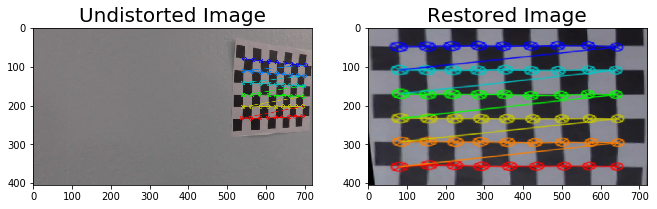

In [2]:
# Reload the camera calibration matrix and distortion conefficients 
scale = 720/1280 # Scale the 1280 image down to 720 image
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "camera_cal/720x540_cal_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
# Read in an image
img = cv2.imread('camera_cal/calibration14.jpg')
rows, cols, chs = img.shape
img = cv2.resize(img,(int(cols*scale),int(rows*scale)))
#img = cv2.resize(img,(720,405))
undist = cv2.undistort(img, mtx, dist, None, mtx)
gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
rows, cols, chs = img.shape
#print(rows, cols)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
#print (corners[0], corners[-nx], corners[-1], corners[nx-1])
#print('Object point coordinates:', objp[-1], objp[-nx], objp[0], objp[nx-1])
#print ('Actual corners coordinates:', corners[-1], corners[-nx], corners[0], corners[nx-1])
# If found, add object points, image points
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(undist, (nx,ny), corners, ret)
    
    offsetx = 80 # offset columns for dst points
    offsety = 48 # offset rows for dst points
    
    # For source points I'm grabbing the outer four detected corners
    src = np.float32([corners[-1], corners[-nx], corners[0], corners[nx-1]]) # 180 deg rotation
    #src = np.float32([corners[nx-1],corners[0], corners[-nx], corners[-1]])  # zero deg rotation
    
    dst = np.float32([[offsetx, offsety], [cols-offsetx, offsety], 
                                     [cols-offsetx, rows-offsety], 
                                     [offsetx, rows-offsety]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M,(cols, rows))


display = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,5))
ax1.imshow(undist,cmap='gray')
ax1.set_title('Undistorted Image', fontsize=20)
ax2.imshow(display,cmap='gray')
ax2.set_title('Restored Image', fontsize=20)

In [3]:
class process:
    
    def __init__(self, image, scale, mtx, dist):

        self.image = image
        self.rows, self.cols, self.chs = image.shape
        self.scale = scale
        self.mtx = mtx
        self.dist = dist
        self.orient = 'x'
        self.apex, self.apey = 360, 240 # Udacity Class Camera
        self.offset_far = 170 #Setup marginal pixels at apex point
        #offset_near = -750
        self.offset_near = -1250 # Marginal pixels at bottom of the image
        self.dsize = (720, 405)

        self.src = np.float32([[int(self.apex-self.offset_far),self.apey],[int(self.apex+self.offset_far),self.apey],\
                               [int(0+self.offset_near),400],[int(720-self.offset_near),400]])
        self.dst = np.float32([[0,0],[720,0],[0,405],[720,405]])
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
        self.Mi = cv2.getPerspectiveTransform(self.dst, self.src)
        self.grad_thresh=(25,130)
        self.sobel_kernel=3
        self.mag_thresh=(50, 255)
        self.canny_thresh = (50, 150)
        self.color=[255, 0, 0]
        self.thickness=4
        self.lines = []
        
        # Define the Hough transform parameters
        self.rho = 1 # distance resolution in pixels of the Hough grid
        self.theta = np.pi/180 # angular resolution in radians of the Hough grid
        self.hough_thresh = 10     # minimum number of votes (intersections in Hough grid cell)
        self.min_line_len = 18 #minimum number of pixels making up a line
        self.max_line_gap = 1    # maximum gap in pixels between connectable line segments
        
    def resize(self):
        return cv2.resize(self.image,(int(self.cols*self.scale),int(self.rows*self.scale)))
    
    def undist(self):
        self.undist = cv2.undistort(self.resize(), self.mtx, self.dist, None, self.mtx)
        return self.undist
        
    def perspective_transform(self): 
        # Take undistort image and warp to bird view
        warped = cv2.warpPerspective(self.undist(), self.M, self.dsize, flags = cv2.INTER_LINEAR)
        return warped
    
    def abs_sobel_thresh(self): # Define a function that takes an image, gradient orientation
        # Convert to grayscale
        gray = cv2.cvtColor(self.resize(), cv2.COLOR_RGB2GRAY)
        # Apply x or y gradient with the OpenCV Sobel() function
        # and take the absolute value
        if self.orient == 'x':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
        if self.orient == 'y':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
        # Rescale back to 8 bit integer
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        # Create a copy and apply the threshold
        binary_output = np.zeros_like(scaled_sobel)
        # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
        binary_output[(scaled_sobel >= self.grad_thresh[0]) & (scaled_sobel <= self.grad_thresh[1])] = 1
        return binary_output
    
    
    def mag_thresh(self): # Define a function to return the magnitude of the gradient
        # Convert to grayscale
        gray = cv2.cvtColor(self.resize(), cv2.COLOR_RGB2GRAY)
        # Take both Sobel x and y gradients
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=self.sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=self.sobel_kernel)
        # Calculate the gradient magnitude
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        # Rescale to 8 bit
        scale_factor = np.max(gradmag)/255 
        gradmag = (gradmag/scale_factor).astype(np.uint8) 
        # Create a binary image of ones where threshold is met, zeros otherwise
        binary_output = np.zeros_like(gradmag)
        binary_output[(gradmag >= self.mag_thresh[0]) & (gradmag <= self.mag_thresh[1])] = 1
        # Return the binary image
        return binary_output
    
    def draw_hough_lines(self):
        #line_img = np.zeros((self.canny().shape, 3), dtype=np.uint8)
        output = np.zeros_like(self.canny())
        lines = self.hough_lines() 
        #car_marker = []
        for line in lines:
            for x1,y1,x2,y2 in line:
                if (x2-x1) != 0:   # Make sure do not divide by zero
                    if abs(y2-y1)/(x2-x1) < 12 and min(y1, y2) > 100: 
                                                
                        line_img = cv2.line(output, (x1,y1), (x2, y2), self.color, self.thickness)
        return line_img
    
    def canny(self):
        gray = cv2.cvtColor(self.resize(), cv2.COLOR_RGB2GRAY)
        return cv2.Canny(gray, self.canny_thresh[0], self.canny_thresh[1])
    
    def hough_lines(self):
        hough = cv2.HoughLinesP(self.canny(), self.rho, self.theta, self.hough_thresh, np.array([]),\
                                minLineLength=self.min_line_len, maxLineGap=self.max_line_gap)
        return hough
    
    def unwarp(self):
        unwarp = perspective_transform(radar, Mi)
    
    def car_marker(self):
        warped = self.perspective_transform()
        gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
        canny = cv2.Canny(gray, self.canny_thresh[0], self.canny_thresh[1])
        warp_zero = np.zeros_like(warped)
        hough = cv2.HoughLinesP(canny, self.rho, self.theta, self.hough_thresh, np.array([]),\
                                minLineLength=self.min_line_len, maxLineGap=self.max_line_gap)
        global line_img
        for line in hough:
            for x1,y1,x2,y2 in line:
                if (x2-x1) != 0: # Make sure do not divid by zero
                    # filter out extra lines, keep only interested region. 
                    if -1.99<(y2-y1)/(x2-x1)< 1.99 and 200<max(y1,y2)<380 and 70<min(x1,x2) and max(x1,x2)<650:
                                                       
                        line_img = cv2.line(warp_zero, (x1, y1), (x2, y2), self.color, self.thickness)
        
        unwarped = cv2.warpPerspective(line_img, self.Mi, self.dsize, flags = cv2.INTER_LINEAR)
        # Combine the result with the original image, with random brightness
        random_bright = np.random.uniform(0.1,1)
        result = cv2.addWeighted(self.resize(), random_bright, unwarped, 0.9, 0)
        #result = cv2.addWeighted(self.resize(), 1, unwarped, 0.9, 0)
    
        return unwarped


In [4]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def pipeline(img):
    marker = process(img, scale, mtx, dist)
    return process.car_marker(marker)

write_output = './test_video_out3.mp4'
clip1 = VideoFileClip('./test_video.mp4')
write_clip = clip1.fl_image(pipeline)    #NOTE: this function expects color images!!
%time write_clip.write_videofile(write_output, audio=False)


[MoviePy] >>>> Building video ./test_video_out3.mp4
[MoviePy] Writing video ./test_video_out3.mp4


 97%|█████████▋| 38/39 [00:02<00:00, 18.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_video_out3.mp4 

CPU times: user 9 s, sys: 64 ms, total: 9.06 s
Wall time: 2.24 s


In [6]:
HTML("""
<video width="720" height="405" controls>
  <source src="{0}">
</video>
""".format(write_output))

In [7]:
# Credit to https://github.com/matthewzimmer/CarND-Vehicle-Detection-P5/blob/master/final-project.ipynb
class Params():
    def __init__(
        self, 
        colorspace='YCrBr',
        orient=9,
        pix_per_cell=4, 
        cell_per_block=4, 
        hog_channel='ALL',
        spatial_size=(32, 32),
        hist_bins=32,
        spatial_feat=True,
        hist_feat=True,
        hog_feat=True
    ):
        self.colorspace = colorspace # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        self.orient = orient # typically between 6 and 12
        self.pix_per_cell = pix_per_cell # HOG pixels per cell
        self.cell_per_block = cell_per_block # HOG cells per block
        self.hog_channel = hog_channel # Can be 0, 1, 2, or "ALL"
        self.spatial_size = spatial_size # Spatial binning dimensions
        self.hist_bins = hist_bins # Number of histogram bins
        self.spatial_feat = spatial_feat # Spatial features on or off
        self.hist_feat = hist_feat # Histogram features on or off
        self.hog_feat = hog_feat  # HOG features on or off

In [8]:
# Read in car and non-car images
cars = glob.glob('./vehicles/*/*.png')
notcars = glob.glob('./non-vehicles/*/*.png')
# Use as much sample as possible, and cars and not cars has same number of samples.
sample_size = min(len(cars), len(notcars)) 
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]


In [9]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [10]:
def extract_hog_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [11]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


In [12]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


In [13]:
# Set params
params = Params(colorspace='YCrCb', orient=8, pix_per_cell=7, cell_per_block=2, hog_channel='ALL') #99.4%

t=time.time()
car_features = extract_features(cars, color_space=params.colorspace, orient=params.orient, 
                        pix_per_cell=params.pix_per_cell, cell_per_block=params.cell_per_block, 
                        hog_channel=params.hog_channel)
notcar_features = extract_features(notcars, color_space=params.colorspace, orient=params.orient, 
                        pix_per_cell=params.pix_per_cell, cell_per_block=params.cell_per_block, 
                        hog_channel=params.hog_channel)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:', params.orient,'orientations',params.pix_per_cell,
    'pixels per cell and', params.cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

142.73 Seconds to extract HOG features...
Using: 8 orientations 7 pixels per cell and 2 cells per block
Feature vector length: 9312
32.6 Seconds to train SVC...
Test Accuracy of SVC =  0.9918
My SVC predicts:  [ 0.  1.  0.  1.  1.  0.  0.  1.  1.  1.]
For these 10 labels:  [ 0.  1.  0.  1.  1.  0.  0.  1.  1.  1.]
0.00346 Seconds to predict 10 labels with SVC


In [48]:
# Save the SVC result for later use 
svc_pickle = {}

svc_pickle["svc"] = svc
svc_pickle["scaler"] = X_scaler
svc_pickle["orient"] = params.orient
svc_pickle["pix_per_cell"] = params.pix_per_cell
svc_pickle["cell_per_block"] = params.cell_per_block
svc_pickle["spatial_size"] = (32,32)
svc_pickle["hist_bins"] = 32
svc_pickle["hog_channel"] = params.hog_channel


pickle.dump( svc_pickle, open( "./svc_pickle.p", "wb" ) )


In [49]:
# Load the SVC result from last saved file
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = svc_pickle["svc"]
X_scaler = svc_pickle["scaler"]
orient = svc_pickle["orient"]
pix_per_cell = svc_pickle["pix_per_cell"]
cell_per_block = svc_pickle["cell_per_block"]
spatial_size = svc_pickle["spatial_size"]
hist_bins = svc_pickle["hist_bins"]
hog_channel = svc_pickle["hog_channel"]

train_acc = svc.score(X_train,y_train)
test_acc = svc.score(X_test,y_test)
print('Training accuracy: ',train_acc)
print('Testing accuracy: ',test_acc)


Training accuracy:  1.0
Testing accuracy:  0.991754336082


In [15]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [16]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

55
[((1224, 380), (1288, 444)), ((888, 380), (952, 444)), ((648, 412), (712, 476)), ((1096, 380), (1160, 444)), ((1000, 412), (1064, 476)), ((1064, 412), (1128, 476)), ((648, 380), (712, 444)), ((952, 412), (1016, 476)), ((1112, 380), (1176, 444)), ((824, 380), (888, 444)), ((872, 380), (936, 444)), ((1000, 412), (1064, 476)), ((904, 380), (968, 444)), ((760, 412), (824, 476)), ((1048, 412), (1112, 476)), ((664, 412), (728, 476)), ((1160, 380), (1224, 444)), ((1128, 380), (1192, 444)), ((760, 380), (824, 444)), ((744, 380), (808, 444)), ((616, 380), (680, 444)), ((632, 380), (696, 444)), ((936, 412), (1000, 476)), ((696, 412), (760, 476)), ((888, 380), (952, 444)), ((680, 380), (744, 444)), ((840, 380), (904, 444)), ((728, 412), (792, 476)), ((744, 380), (808, 444)), ((600, 412), (664, 476)), ((802, 440), (930, 520)), ((898, 400), (1026, 480)), ((642, 400), (770, 480)), ((706, 440), (834, 520)), ((482, 440), (610, 520)), ((546, 400), (674, 480)), ((930, 400), (1058, 480)), ((834, 400),

<function matplotlib.pyplot.show>

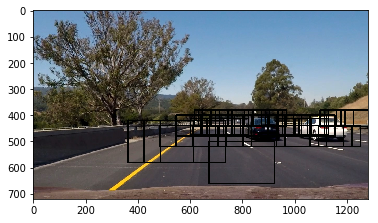

In [17]:
def random_scan_boxes(image, far = 10, mid = 5, near = 3):
    #Create a list to append scan window coordinates
    scan_windows = []
    w_far = slide_window(image, x_start_stop=[600, None], y_start_stop=[380, 500], \
                         xy_window=(64,64), xy_overlap=(0.75, 0.5))
    for i in range (far):
        f = np.random.randint(0, len(w_far))
        scan_windows.append(w_far[f])
        #window_img = draw_boxes(image, windows, color=(0, 255, 255), thick=6)                    

    w_mid = slide_window(image, x_start_stop=[450, None], y_start_stop=[400, 550], \
                         xy_window=(128,80), xy_overlap=(0.75, 0.5))
    for i in range (mid):
        m = np.random.randint(0, len(w_mid))
        scan_windows.append(w_mid[m])
    
        #window_m_img = draw_boxes(window_img, window_m, color=(255, 255, 255), thick=6)                    

    w_near = slide_window(image, x_start_stop=[300, None], y_start_stop=[420, 700], \
                          xy_window=(250,160), xy_overlap=(0.75, 0.5))
    for i in range (near):
        n = np.random.randint(0, len(w_near))
        scan_windows.append(w_near[n])
        
    return scan_windows

image = mpimg.imread('./test_images/test6.jpg').astype(np.float32)/255
boxes = random_scan_boxes(image, far = 30, mid = 20, near = 5)
window_img = draw_boxes(image, boxes, color=(0, 255, 0), thick=4)                    

print(len(boxes))
print(boxes)


#plt.imshow(window_img)
plt.imshow(window_img)
plt.show


In [18]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

1.5 fps
3 [((840, 412), (904, 476)), ((1122, 400), (1250, 480)), ((1122, 400), (1250, 480))]


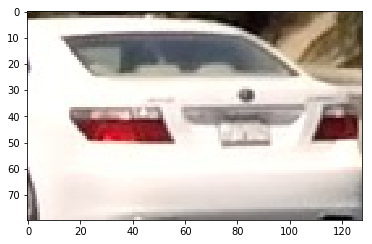

In [19]:
t=time.time()
image = mpimg.imread('./test_images/test4.jpg').astype(np.float32)/255
t=time.time()
boxes = random_scan_boxes(image, far = 40, mid = 20, near = 10)
find_car_img = []
find_car_boxes = []
for box in boxes:
    #print (box[0], box[0][0],box[0][1],box[1][0], box[1][1])
    x1,y1,x2,y2 = box[0][0],box[0][1],box[1][0], box[1][1]
    
    crop = image[y1:y2,x1:x2]  #Normalize .jpg image from 0-255 to 0-1
    resize_img = cv2.resize(crop, (64,64))

    test_feature = single_img_features(resize_img, color_space=params.colorspace, orient=params.orient,\
                                       pix_per_cell=params.pix_per_cell, cell_per_block=params.cell_per_block,\
                                       hog_channel=params.hog_channel,\
                                       spatial_feat=True, hist_feat=True, hog_feat=True)

    scaled_test = X_scaler.transform(test_feature)

    if svc.predict(scaled_test) == 1:
        find_car_img.append(crop)
        find_car_boxes.append(box)
        plt.imshow(crop)
t2=time.time()
print(round(1/(t2-t), 1), 'fps')
print (len(find_car_boxes), find_car_boxes)


In [20]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    global labeled_bboxes
    labeled_bboxes = []
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/405      # approx meters per pixel in y dimension
    xm_per_pix = 3.7/500     # approx meteres per pixel in x dimension
    font = cv2.FONT_HERSHEY_SIMPLEX
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,255,255), 4)
        distance = np.sqrt(((bbox[0][0]-640)*xm_per_pix)**2+((bbox[0][1]-780)*ym_per_pix)**2)
        cv2.putText(img,'Car%s:%.1fm' % (car_number, distance),\
                    (int(bbox[0][0]-10),int(bbox[0][1]-20)), font, 1,(255,255,255),2)
        labeled_bboxes.append((car_number,bbox))
        
    # Return the image
    return img


In [21]:
def car_finder_pipeline(img):
    t=time.time()
    image = img.astype(np.float32)/255 #Normalize .jpg image from 0-255 to 0-1
    t=time.time()
    boxes = random_scan_boxes(image, far = 40, mid = 20, near = 10)
    find_car_img = []
    find_car_boxes = []
    for box in boxes:
        
        x1,y1,x2,y2 = box[0][0],box[0][1],box[1][0], box[1][1]
    
        crop = image[y1:y2,x1:x2]  
        resize_img = cv2.resize(crop, (64,64))

        test_feature = single_img_features(resize_img, color_space=params.colorspace, orient=params.orient,\
                                           pix_per_cell=params.pix_per_cell, cell_per_block=params.cell_per_block,\
                                           hog_channel=params.hog_channel,\
                                           spatial_feat=True, hist_feat=True, hog_feat=True)

        scaled_test = X_scaler.transform(test_feature)

        if svc.predict(scaled_test) == 1:
            find_car_img.append(crop)
            find_car_boxes.append(box)
            # plt.imshow(crop)
            
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat,find_car_boxes)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # from scipy.ndimage.measurements import label
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    #draw_img = draw_labeled_bboxes(np.copy(image), labels)
    draw_img = draw_labeled_bboxes(img, labels)
    
    
    t2=time.time()
    
    return draw_img
    

In [22]:
write_output = './test_video_out36.mp4'
clip1 = VideoFileClip('./test_video.mp4')
write_clip = clip1.fl_image(car_finder_pipeline)    #NOTE: this function expects color images!!
%time write_clip.write_videofile(write_output, audio=False)


[MoviePy] >>>> Building video ./test_video_out36.mp4
[MoviePy] Writing video ./test_video_out36.mp4


 97%|█████████▋| 38/39 [00:22<00:00,  1.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_video_out36.mp4 

CPU times: user 22 s, sys: 276 ms, total: 22.2 s
Wall time: 23.1 s


In [24]:
HTML("""
<video width="720" height="405" controls>
  <source src="{0}">
</video>
""".format(write_output))

#Build and train a Neural Network for vehicle detection and search location

In [25]:
# Read in car and notcar images again
cars = glob.glob('./vehicles/*/*.png')
notcars = glob.glob('./non-vehicles/*/*.png')

In [26]:
# Generate Y Vector
Ynn = np.concatenate([np.ones(len(cars)), np.zeros(len(notcars))-1])

# Read X Vector
Xnn = []
for fname in cars:    
    Xnn.append(scipy.misc.imread(fname))
for fname in notcars:    
    Xnn.append(scipy.misc.imread(fname))
Xnn = np.array(Xnn)

In [27]:
Xnn_train, Xnn_test, Ynn_train, Ynn_test = train_test_split(Xnn, Ynn, test_size=0.10, random_state=42)


Xnn_train = Xnn_train.astype('float32')
Xnn_test = Xnn_test.astype('float32')
print('Xnn_train shape:', Xnn_train.shape)
print(Xnn_train.shape[0], 'train samples')
print(Xnn_test.shape[0], 'test samples')
input_shape =  (3,64,64)

Xnn_train shape: (15984, 64, 64, 3)
15984 train samples
1776 test samples


In [28]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Lambda
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K


def get_conv(input_shape=(64,64,3), filename=None):
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=input_shape, output_shape=input_shape))
    model.add(Convolution2D(10, 3, 3, activation='relu', name='conv1',input_shape=input_shape, border_mode="same"))
    model.add(Convolution2D(10, 3, 3, activation='relu', name='conv2',border_mode="same"))
    model.add(MaxPooling2D(pool_size=(8,8)))
    model.add(Dropout(0.25))
    model.add(Convolution2D(128,8,8,activation="relu",name="dense1")) # This was Dense(128)
    model.add(Dropout(0.5))
    model.add(Convolution2D(1,1,1,name="dense2", activation="tanh")) # This was Dense(1)
    if filename:
        model.load_weights(filename)        
    return model

model = get_conv()
model.add(Flatten())
model.compile(loss='mse',optimizer='adadelta',metrics=['accuracy'])


Using TensorFlow backend.


In [37]:
### Train the Neural Network, and save the weights for futher use

model.fit(Xnn_train, Ynn_train, batch_size=128, nb_epoch=20, verbose=1, validation_data=(Xnn_test, Ynn_test))
score = model.evaluate(Xnn_test, Ynn_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
model.save_weights("localizer2.h5")

Train on 15984 samples, validate on 1776 samples
Epoch 1/20
15984/15984 [==============================] - 2s - loss: 0.0149 - acc: 0.9909 - val_loss: 0.0126 - val_acc: 0.9938

In [38]:
heatmodel = get_conv(input_shape=(None,None,3), filename="localizer2.h5")

In [39]:
def locate(img, windows = None):
    #The function take any size input image, and region windows, it will find the vehicle within the region. 
    #Return marked heatmap and car bonding box coord
    
    heatmap = heatmodel.predict(img.reshape(1,img.shape[0],img.shape[1],img.shape[2]))
    
    location = []
    
    xx, yy = np.meshgrid(np.arange(heatmap.shape[2]),np.arange(heatmap.shape[1]))
    x = (xx[heatmap[0,:,:,0]>0.99])
    y = (yy[heatmap[0,:,:,0]>0.99])
        
    # Draw the box onto the blank image
    map_zero = np.zeros_like(img).astype(np.uint8)
    if len(windows) != 0:
        for win in windows:
            x1, y1, x2, y2 = win[0][0], win[0][1], win[1][0], win[1][1]
            for i,j in zip(x,y):
                # detection window within search windows
                if min(x1,x2)< i*8+32 < max(x1,x2) and min(y1,y2)< j*8+32<max(y1,y2):
                    cv2.rectangle(map_zero, (i*8,j*8), (i*8+64,j*8+64), (0,0,255), 2)
                    location.append(([i*8,j*8],[i*8+64, j*8+64]))
    return map_zero, location

10.9 fps


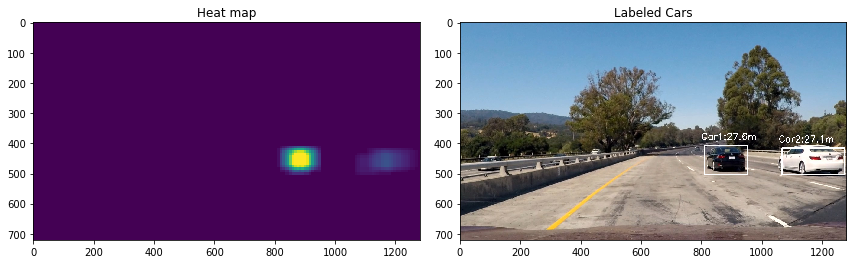

In [43]:
t=time.time()
full_img = mpimg.imread('./test_images/test1.jpg')
windows = random_scan_boxes(image, far = 20, mid = 20, near = 5)
heat = np.zeros_like(full_img[:,:,0]).astype(np.float)

heatmap_NN, location = locate(full_img, windows=windows)


# Add heat to each box in box list


heat = add_heat(heat,location)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,5)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

#from scipy.ndimage.measurements import label
# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(full_img), labels)

t2=time.time()
print(round(1/(t2-t), 1), 'fps')
#print (location)
#plt.imshow(heatmap_NN)

fig = plt.figure(figsize=(12,5))
#fig = plt.figure(12,5)
plt.subplot(121)
plt.imshow(heatmap)
plt.title('Heat map')
plt.subplot(122)
plt.imshow(draw_img, cmap='hot')
plt.title('Labeled Cars')
fig.tight_layout()

In [44]:
def NN_pipeline(image):
    t=time.time()
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/405      # approx meters per pixel in y dimension
    xm_per_pix = 3.7/500     # approx meteres per pixel in x dimension
    font = cv2.FONT_HERSHEY_SIMPLEX
    # copy a image to draw final output    
    f_image = np.copy(image)
    
    global location, heatmap_NN, heat, find_car_boxes, labeled_bboxes, draw_img, img_count
    #marker = cv2.resize(pipeline(image), (1280, 720))
    heat = np.zeros_like(f_image[:,:,0]).astype(np.float)
    
    #heat = add_heat(marker, location)
    if len(labeled_bboxes) == 0:
    #if len(find_car_boxes) == 0:
        # Apply random scanning windows 
        windows = random_scan_boxes(image, far = 20, mid = 20, near = 5)
        # Use Neroual Network to find car and heatmap
        heatmap_NN, location = locate(image, windows)
        # Add heat to each box in box list
        #heat = add_more_heat(heat, find_car_boxes, location)
        heat = add_heat(heat, location)
    
        # Apply threshold to help remove false positives
    
        heat = apply_threshold(heat,5)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        # from scipy.ndimage.measurements import label
        # Find final boxes from heatmap using label function
        labels = label(heatmap_NN)
        #draw_img = draw_labeled_bboxes(np.copy(image), labels)
        draw_img = draw_labeled_bboxes(f_image, labels)
    else:
        
        norm_image = f_image.astype(np.float32)/255 #Normalize .jpg image from 0-255 to 0-1
        
        #boxes = random_scan_boxes(image, far = 20, mid = 10, near = 5)
        find_car_img = []
        find_car_boxes = []
        for box in labeled_bboxes:
        #for box in boxes:
        
            x1,y1,x2,y2 = box[1][0][0],box[1][0][1],box[1][1][0], box[1][1][1]
            #x1,y1,x2,y2 = box[0][0],box[0][1],box[1][0], box[1][1]
    
            crop = norm_image[y1:y2,x1:x2]  
            resize_img = cv2.resize(crop, (64,64))

            test_feature = single_img_features(resize_img, color_space=params.colorspace, orient=params.orient,\
                                               pix_per_cell=params.pix_per_cell, cell_per_block=params.cell_per_block,\
                                               hog_channel=params.hog_channel,\
                                               spatial_feat=True, hist_feat=True, hog_feat=True)

            scaled_test = X_scaler.transform(test_feature)

            if svc.predict(scaled_test) == 1:
                #font = cv2.FONT_HERSHEY_SIMPLEX
                distance = np.sqrt(((box[1][0][0]-640)*xm_per_pix)**2+((box[1][0][1]-780)*ym_per_pix)**2)
                draw_img = cv2.putText(f_image,'Car%s:%.1fm' % (box[0], distance),\
                                       (int(box[1][0][0]-10),int(box[1][0][1]-20)), font, 1,(255,255,255),2)
                cv2.rectangle(draw_img, box[1][0], box[1][1], (255,255,255), 4)
                #find_car_img.append(crop)
                find_car_boxes.append(box)
            else: 
                labeled_bboxes = []   # Reset the pipeline
            
    img_count +=1 
    t2=time.time()
    
    return draw_img

In [45]:
labeled_bboxes = []
img_count = 0
write_output = './project_video_out37.mp4'
clip1 = VideoFileClip('./project_video.mp4')
write_clip = clip1.fl_image(NN_pipeline)    #NOTE: this function expects color images!!
%time write_clip.write_videofile(write_output, audio=False)


[MoviePy] >>>> Building video ./project_video_out37.mp4
[MoviePy] Writing video ./project_video_out37.mp4


100%|█████████▉| 1260/1261 [00:53<00:00, 23.73it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_out37.mp4 

CPU times: user 50.4 s, sys: 2.67 s, total: 53.1 s
Wall time: 53.8 s


In [46]:
HTML("""
<video width="720" height="405" controls>
  <source src="{0}">
</video>
""".format(write_output))

In [50]:
#print (location)
print (find_car_boxes)
print (labeled_bboxes)



[(1, ((1167, 391), (1279, 481))), (2, ((735, 399), (873, 497)))]
[(1, ((1167, 391), (1279, 481))), (2, ((735, 399), (873, 497)))]
